In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import datetime
import re

In [ ]:
#todo:
#!!Passendes UI Framework finden, implementieren: (möglichkeit zu anpassung welche visualisierungen geladen werden sollen. nice to have: dynamische anordnung von gewünschten visualisierunngen)
#!!Visualisierungen bauen: funktionen für einzelne visualisierungen, damit nur die gewollten auch geladen werden (performance)
#Weitere Analysen bauen (wenn ideen vorhanden/notwenig)
#


In [1]:
#man könnte auch die crawlerlib class importieren
def getSoup(wikipage):
	#get page to soup
	page = requests.get(wikipage)
		
	soup = BeautifulSoup(page.content, 'html.parser')
	return soup

def getHeadline(soup):
	#article name / headline
	headline = soup.findAll('h1')[0].getText()
	return headline
	
def getTextBody(wikipage):
	#limit soup to actual article content
	soup = getSoup(wikipage)
	body = soup.select('#mw-content-text > div.mw-parser-output')[0]
	try:
		for tag in body.findAll('table'):
			tag.decompose()
	except:
		print('No table found')

	try:
		for tag in body.findAll('div', {'class':'shortdescription nomobile noexcerpt noprint searchaux'}):
			tag.decompose()
	except:
		print('No shortdescription found') 
		
	try:
		for tag in body.findAll('ol', {'class':'references'}):
			tag.decompose()
	except:
		print('No references found') 
		
	try:
		for tag in body.findAll('abbr'):
			tag.decompose()
	except:
		print('No abbriviation found') 
		
	x = str(body)
	body_headlines = []
	body_text = []

	c = 1

	z = x.split('h2')

	for i in z:
		if c%2 == 1:
			body_text.append(i)
		else:
			body_headlines.append(i)
		c+=1
	headlines = []

	for i in body_headlines:
		soup = BeautifulSoup(i, 'html.parser')
		headlines.append(soup.text)
	headlines_body = [i.replace(' id="mw-toc-heading">Contents</', 'Contents') for i in headlines]
	headlines_body = [i.replace('>', '') for i in headlines_body]
	headlines_body = [i.replace('[edit]</', '') for i in headlines_body]
	text = []

	for i in body_text:
		soup = BeautifulSoup(i, 'html.parser')
		text.append(soup.text)
	text_body = [i.replace('\n', '') for i in text]
	text_body = [i.replace('>', '') for i in text_body]
	text_body = [i.replace('<', '') for i in text_body]
	first_lines = text_body[0]
	#headlines_body
	ref_id = ['Contents', 'References', 'Notes', 'Sources', 'External link','Notes, citations, and references', 'Bibliography', 'Works cited']

	for i in ref_id:
		z = 0
		for e in headlines_body:
			if e == i:
				headlines_body.remove(e)
				print(z)
				text_body.pop(z)
			else:
				z += 1
	c = len(headlines_body)

	if c == 0:
		c = 1

	r = 0

	final_elements = []

	while r < c:
		if r == 0:
			final_elements.append(first_lines)
		if len(headlines_body) == 0 :
			break
		else:
			final_elements.append(headlines_body[r])
			final_elements.append(text_body[r])
		r += 1
	cleaned_list = [i.replace('[edit]', ' ') for i in final_elements]
	cleaned_list = [i.replace('\xa0', ' ') for i in cleaned_list]


	final_list =[]

	for i in cleaned_list:
		match = re.sub(r'\[\d{1,3}]', '', i)
		final_list.append(match)
		
	final = []

	for i in final_list:
		x = i + '\n\n'
		final.append(x)
	list1 = ' '.join(final)
	body2 = BeautifulSoup(list1, 'html.parser')
		
	return body2
	
def getImgCnt(soup):
	#drop content after 'References' section (for imagecount)
	body = soup.select('#mw-content-text > div.mw-parser-output')[0]
	ref_id = ['"References"', '"Notes"', '"Sources"', '"External_links"','"Notes,_citations,_and_references"', '"Bibliography"', '"See_also"', '"Further_reading"', '"Works_cited"']
	for id in ref_id:
		try:
			body_str = str(body).split(f'<span class="mw-headline" id={id}')[0]
			body = BeautifulSoup(body_str, 'html.parser')
			#body.find('span', {'class':'mw-headline', 'id':id}).decompose()
		except:
			print(id+': No such element found!')
		

	#get number of images in the article
	img_count = len(body.findAll('img'))
	return img_count

# Google Trends

In [4]:
pip install pytrends

Note: you may need to restart the kernel to use updated packages.


In [5]:
import requests
import lxml
import pandas as pd
from pytrends.request import TrendReq
import matplotlib.pyplot as plt

In [6]:
pytrends = TrendReq(hl='en-US', tz=360)

In [7]:
# userinput = Platzhalter für globale variable generiert aus userauswahl über dropdown

userinput = ["NLP"]

In [8]:
pytrends.build_payload(userinput, cat=0, timeframe='2015-01-01 2021-12-31', geo='US', gprop='')

In [9]:
# nicht relevant für endprodukt, nur für testphase: überprüft, welche Infos mit dem im userinput übergebenen text verknüpft sind

keywords = pytrends.suggestions(keyword=userinput[0])
df = pd.DataFrame(keywords)
df.drop(columns= 'mid')

,title,type
0,Neuro-linguistic programming,Topic
1,Natural language processing,Topic
2,Nonsteroidal anti-inflammatory drug,Drug class
3,Nonlinear programming,Topic
4,Neuro-linguistic Programming for Dummies,Book by Kate Burton and Romilla Ready


In [10]:
# suchtrends als dataframe (evtl. noch interessant zum integrieren in datenbank, zwecks overload-vermeidung der gtrendsapi)

dfg = pytrends.interest_over_time()
print(dfg.head(10))

            NLP  isPartial
date                      
2015-01-01   37      False
2015-02-01   42      False
2015-03-01   51      False
2015-04-01   57      False
2015-05-01   49      False
2015-06-01   45      False
2015-07-01   45      False
2015-08-01   44      False
2015-09-01   47      False
2015-10-01   48      False


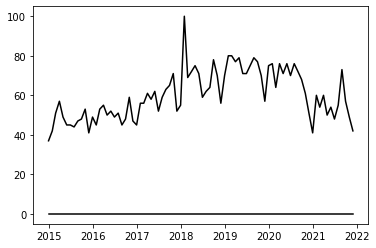

In [11]:
# TODO: das geht hübscher!

plt.figure()
plt.plot(dfg,'k')